In [8]:
import argparse
import time 
import numpy as np
from dataset import *
from models import * 
from utils import *
from generation import *

from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DIR_PATH = "dataset/poems.csv"
SOV_TOKEN = "<SOV>" # start of verse
EOV_TOKEN = "<EOV>" # end of verse
encoder_ckpt = "saved_models/encoder_3.pt"
decoder_ckpt = "saved_models/decoder_3.pt"

parser = argparse.ArgumentParser()
parser.add_argument('--max_epochs', type=int, default=30)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--sequence_length', type=int, default=10)
args, unknown = parser.parse_known_args()

# Define the dataset and dataloader
dataset = SpanishPoemsDataset(DIR_PATH, SOV_TOKEN, EOV_TOKEN, args)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

print(dataset.__getitem__(3))
print('Vocab:', len(dataset.unique_words))

(tensor([2449, 1375,    1,    0,    6,   15, 2450, 2451,    5,   66]), tensor([1375,    1,    0,    6,   15, 2450, 2451,    5,   66, 2452]))
Vocab: 7506


# TRAINING

In [9]:
# Set hyperparameters

input_size = len(dataset.unique_words) # size of the vocabulary for the input sequence
output_size = len(dataset.unique_words) # size of the vocabulary for the target sequence
hidden_size = 128
num_layers = 1
batch_size = args.batch_size
sequence_length = args.sequence_length
num_epochs = args.max_epochs
learning_rate = 0.001
save_epochs = 2

# Instantiate the encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(hidden_size, output_size, num_layers)

# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

What has changed:

- The initialization of the encoder hidden state now includes both the hidden state and the cell state.
- The forward pass in the encoder now returns both the updated hidden state and the updated cell state as a tuple.
- The initialization of the decoder hidden state now only includes the hidden state, as GRU does not have a cell state.
- The forward pass in the decoder remains the same since it is independent of the encoder architecture.
- The backward pass and optimization steps remain the same.
- The saving of the model after each epoch remains the same.
- The average loss calculation and printing also remain the same.

In [10]:
# Training loop
start_time = time.time()
loss_history = []
encoder.train()
decoder.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for batch_inputs, batch_targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Initialize the hidden state and cell state of the encoder
        hidden, cell_state = encoder.init_hidden(sequence_length)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass - Encoder
        encoder_outputs, (hidden, cell_state) = encoder(batch_inputs, (hidden, cell_state))

        # Initialize the hidden state and cell state of the decoder
        decoder_hidden = hidden[:, 1:sequence_length, :].contiguous()
        decoder_cell_state = cell_state[:, 1:sequence_length, :].contiguous()

        # Prepare the input and target sequences for the decoder
        decoder_inputs = batch_targets[:, :-1]
        decoder_targets = batch_targets[:, 1:]

        # Forward pass - Decoder
        decoder_outputs, _ = decoder(decoder_inputs, (decoder_hidden, decoder_cell_state))

        # Calculate the loss
        loss = criterion(decoder_outputs.reshape(-1, output_size), decoder_targets.reshape(-1))

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save the model after each epoch
    if epoch % save_epochs == 0:
        print("-> Saving checkpoint") 
        torch.save(encoder.state_dict(), encoder_ckpt)
        torch.save(decoder.state_dict(), decoder_ckpt)

    # Print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time/3600) 

Epoch 1/30: 100%|██████████| 323/323 [01:17<00:00,  4.14it/s]


-> Saving checkpoint
Epoch 1/30, Loss: 5.8538


Epoch 2/30: 100%|██████████| 323/323 [01:16<00:00,  4.20it/s]


Epoch 2/30, Loss: 5.1388


Epoch 3/30: 100%|██████████| 323/323 [01:13<00:00,  4.41it/s]


-> Saving checkpoint
Epoch 3/30, Loss: 4.8857


Epoch 4/30: 100%|██████████| 323/323 [01:16<00:00,  4.20it/s]


Epoch 4/30, Loss: 4.6343


Epoch 5/30: 100%|██████████| 323/323 [01:12<00:00,  4.44it/s]


-> Saving checkpoint
Epoch 5/30, Loss: 4.3911


Epoch 6/30: 100%|██████████| 323/323 [01:16<00:00,  4.21it/s]


Epoch 6/30, Loss: 4.1595


Epoch 7/30: 100%|██████████| 323/323 [01:13<00:00,  4.42it/s]


-> Saving checkpoint
Epoch 7/30, Loss: 3.9414


Epoch 8/30: 100%|██████████| 323/323 [01:13<00:00,  4.38it/s]


Epoch 8/30, Loss: 3.7492


Epoch 9/30: 100%|██████████| 323/323 [01:22<00:00,  3.89it/s]


-> Saving checkpoint
Epoch 9/30, Loss: 3.5284


Epoch 10/30: 100%|██████████| 323/323 [01:29<00:00,  3.63it/s]


Epoch 10/30, Loss: 3.3574


Epoch 11/30: 100%|██████████| 323/323 [01:23<00:00,  3.87it/s]


-> Saving checkpoint
Epoch 11/30, Loss: 3.1519


Epoch 12/30: 100%|██████████| 323/323 [01:28<00:00,  3.63it/s]


Epoch 12/30, Loss: 2.9724


Epoch 13/30: 100%|██████████| 323/323 [01:23<00:00,  3.89it/s]


-> Saving checkpoint
Epoch 13/30, Loss: 2.8096


Epoch 14/30: 100%|██████████| 323/323 [01:22<00:00,  3.92it/s]


Epoch 14/30, Loss: 2.6610


Epoch 15/30: 100%|██████████| 323/323 [01:28<00:00,  3.67it/s]


-> Saving checkpoint
Epoch 15/30, Loss: 2.5283


Epoch 16/30: 100%|██████████| 323/323 [01:22<00:00,  3.90it/s]


Epoch 16/30, Loss: 2.4047


Epoch 17/30: 100%|██████████| 323/323 [01:28<00:00,  3.64it/s]


-> Saving checkpoint
Epoch 17/30, Loss: 2.2750


Epoch 18/30: 100%|██████████| 323/323 [01:22<00:00,  3.91it/s]


Epoch 18/30, Loss: 2.1531


Epoch 19/30: 100%|██████████| 323/323 [01:22<00:00,  3.92it/s]


-> Saving checkpoint
Epoch 19/30, Loss: 2.0421


Epoch 20/30: 100%|██████████| 323/323 [01:17<00:00,  4.15it/s]


Epoch 20/30, Loss: 1.9420


Epoch 21/30: 100%|██████████| 323/323 [01:20<00:00,  4.03it/s]


-> Saving checkpoint
Epoch 21/30, Loss: 1.8427


Epoch 22/30: 100%|██████████| 323/323 [01:26<00:00,  3.73it/s]


Epoch 22/30, Loss: 1.7532


Epoch 23/30: 100%|██████████| 323/323 [01:30<00:00,  3.58it/s]


-> Saving checkpoint
Epoch 23/30, Loss: 1.6629


Epoch 24/30: 100%|██████████| 323/323 [01:21<00:00,  3.98it/s]


Epoch 24/30, Loss: 1.5712


Epoch 25/30: 100%|██████████| 323/323 [01:18<00:00,  4.14it/s]


-> Saving checkpoint
Epoch 25/30, Loss: 1.4954


Epoch 26/30: 100%|██████████| 323/323 [01:14<00:00,  4.35it/s]


Epoch 26/30, Loss: 1.4217


Epoch 27/30: 100%|██████████| 323/323 [01:17<00:00,  4.15it/s]


-> Saving checkpoint
Epoch 27/30, Loss: 1.3462


Epoch 28/30: 100%|██████████| 323/323 [01:16<00:00,  4.24it/s]


Epoch 28/30, Loss: 1.2786


Epoch 29/30: 100%|██████████| 323/323 [01:14<00:00,  4.32it/s]


-> Saving checkpoint
Epoch 29/30, Loss: 1.2156


Epoch 30/30: 100%|██████████| 323/323 [01:21<00:00,  3.96it/s]

Epoch 30/30, Loss: 1.1566
Elapsed time:  0.6731404768096076


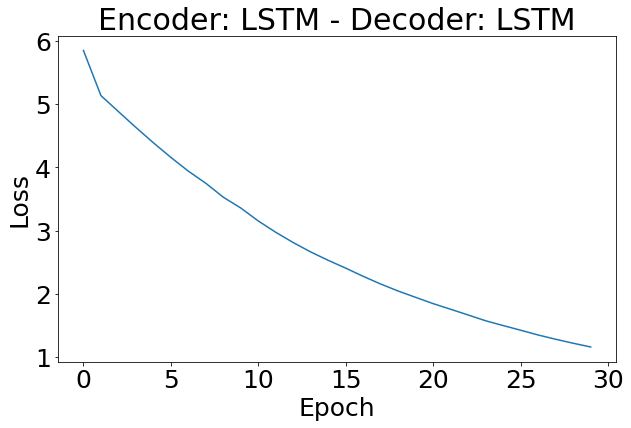

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 25
plt.figure(figsize=(10,6))
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Encoder: LSTM - Decoder: LSTM")
#plt.savefig("loss_512.jpg", bbox_inches='tight')
plt.show()

# GENERATE POEM 

In [17]:
poem, perplexity = generate_poem_LSTM(
    encoder, decoder, dataset, 
    0, 1, max_length=50, temperature=0.8, top_k=10, 
    encoder_ckpt=encoder_ckpt, 
    decoder_ckpt=decoder_ckpt
)

print('')
print(poem)
print('Perplexity: ', perplexity)


que se queja los paisajes
y tú se va allá a la sangre
del lado de pluma
paz para el corazón desgarrado
de las estrellas que te cases paz para el río
y de las horas serenas
la
Perplexity:  10.238013632137365
